# Train, tune, and deploy a custom ML model using the Time Series Anomaly Detection (LSTM-AE) Algorithm from AWS Marketplace

The [Time Series Anomaly Detection (LSTM-AE) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-up2haipz3j472) performs time series anomaly detection with a Long Short-Term Memory Network Autoencoder (LSTM-AE). It implements both training and inference from CSV data and supports both CPU and GPU instances. The training and inference Docker images were built by extending the PyTorch 2.1.0 Python 3.10 SageMaker containers. 

**Model Overview**

The LSTM-AE model reconstructs the time series with an LSTM autoencoder.
The encoder and decoder consist of a single LSTM layer and have the same number of hidden units.
The encoder takes as input the time series and returns the hidden states.
The hidden states of the encoder are used for initializing the hidden states of the decoder, which reconstructs the time series in reversed order. 
The autoencoder parameters are learned on a training set containing only normal data (i.e. without anomalies) by minimizing the mean squared error (MSE) between the actual and reconstructed values of the time series.

After the model has been trained, a multivariate Gaussian distribution is fitted to the model's reconstruction errors on an independent validation set (also without anomalies) using Maximum Likelihood Estimation (MLE). 
At inference time, the model reconstructs the values of all the time series (which can now include anomalies) and calculates the squared Mahalanobis distance between the reconstruction errors and the Gaussian distribution previously estimated on normal data. 
The computed squared Mahalanobis distance is then used as an anomaly score: the larger the squared Mahalanobis distance at a given a time step, the more likely the time step is to be an anomaly.

<img src=https://fg-research-assets.s3.eu-west-1.amazonaws.com/lstm-ae-diagram.png style="width:80%;margin-top:60px;margin-bottom:50px"/> 

*LSTM-AE architecture (source: [doi: 10.48550/arXiv.1607.00148](https://doi.org/10.48550/arXiv.1607.00148))*

**Model Resources**

- **Paper:** [LSTM-based Encoder-Decoder for Multi-Sensor Anomaly Detection](https://doi.org/10.48550/arXiv.1607.00148).

This sample notebook shows you how to train a custom ML model using the [Time Series Anomaly Detection (LSTM-AE) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-up2haipz3j472).

**Note: This is a reference notebook and it cannot run unless you make the changes suggested in the notebook.**

## Pre-requisites
1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Anomaly Detection (LSTM-AE) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-up2haipz3j472)

## Contents
1. [Subscribe to the algorithm](#1.-Subscribe-to-the-algorithm)
1. [Prepare dataset](#2.-Prepare-dataset)
	1. [Dataset format expected by the algorithm](#A.-Dataset-format-expected-by-the-algorithm)
	1. [Configure and visualize train and test dataset](#B.-Configure-and-visualize-train-and-test-dataset)
	1. [Upload datasets to Amazon S3](#C.-Upload-datasets-to-Amazon-S3)
1. [Train a machine learning model](#3:-Train-a-machine-learning-model)
	1. [Set up environment](#3.1-Set-up-environment)
	1. [Train a model](#3.2-Train-a-model)
1. [Deploy model and verify results](#4:-Deploy-model-and-verify-results)
    1. [Deploy trained model](#A.-Deploy-trained-model)
    1. [Create input payload](#B.-Create-input-payload)
    1. [Perform real-time inference](#C.-Perform-real-time-inference)
    1. [Visualize output](#D.-Visualize-output)
    1. [Calculate relevant metrics](#E.-Calculate-relevant-metrics)
    1. [Delete the endpoint](#F.-Delete-the-endpoint)
1. [Tune your model! (optional)](#5:-Tune-your-model!-(optional))
	1. [Tuning Guidelines](#A.-Tuning-Guidelines)
	1. [Define Tuning configuration](#B.-Define-Tuning-configuration)
	1. [Run a model tuning job](#C.-Run-a-model-tuning-job)
1. [Perform Batch inference](#6.-Perform-Batch-inference)
1. [Clean-up](#7.-Clean-up)
	1. [Delete the model](#A.-Delete-the-model)
	1. [Unsubscribe to the listing (optional)](#B.-Unsubscribe-to-the-listing-(optional))


## Usage instructions
You can run this notebook one cell at a time (by using Shift+Enter for running a cell).

## 1. Subscribe to the algorithm

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:<...>"

## 2. Prepare dataset

In [2]:
import io
import datetime
import boto3
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.0' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:
# SageMaker session
sagemaker_session = sagemaker.Session()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### A. Dataset format expected by the algorithm

The training and validation datasets should be provided as CSV files. 
Each column of the CSV file represents a time series, while each row represents a time step.
All the time series should have the same length and should not contain missing values.
The CSV file should not contain any index column or column headers. 

You can find more information about dataset format in the **Usage Information** section of the algorithm listing page.

### B. Configure and visualize train and test dataset

The sample data provided in the algorithm's [GitHub repository](https://github.com/fg-research/lstm-ae-sagemaker) consists of two artificially generated time series. The training dataset contains 15000 samples, while the validation and test datasets contain 5000 samples. 

**Training dataset:**

In [4]:
training_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/lstm-ae-sagemaker/master/data/training/train.csv",
    header=None,
    index_col=None
)

In [5]:
training_dataset.shape

(15000, 2)

In [6]:
training_dataset.head()

,0,1
0,-10.302054,-9.879548
1,-9.761644,-11.455176
2,-10.185059,-12.195165
3,-12.834404,-10.253211
4,-13.341993,-13.015417


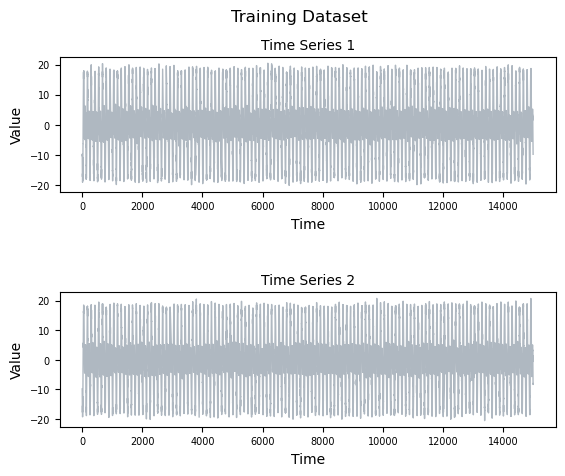

In [7]:
fig, axs = plt.subplots(nrows=training_dataset.shape[1], ncols=1, sharex=True)
for i in range(training_dataset.shape[1]):
    axs[i].plot(training_dataset.iloc[:, i], color="#AFB8C1", lw=1)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Training Dataset")
fig.show()

**Validation dataset:**

In [8]:
validation_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/lstm-ae-sagemaker/master/data/training/valid.csv",
    header=None,
    index_col=None
)

In [9]:
validation_dataset.shape

(5000, 2)

In [10]:
validation_dataset.head()

,0,1
0,-9.728953,-11.809606
1,-11.821012,-12.637485
2,-11.422567,-11.136945
3,-12.757596,-14.022805
4,-13.126208,-12.558090


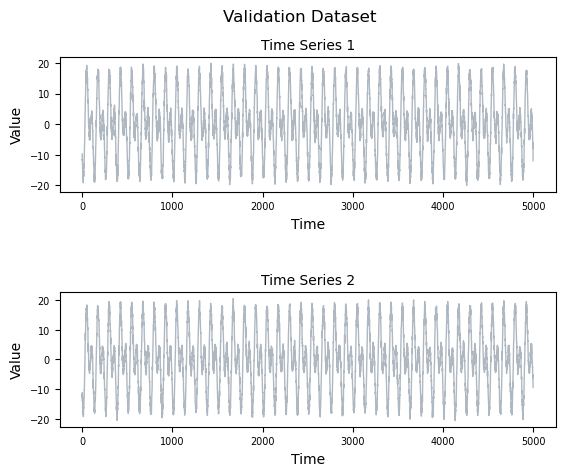

In [11]:
fig, axs = plt.subplots(nrows=validation_dataset.shape[1], ncols=1, sharex=True)
for i in range(validation_dataset.shape[1]):
    axs[i].plot(validation_dataset.iloc[:, i], color="#AFB8C1", lw=1)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Validation Dataset")
fig.show()

### C. Upload datasets to Amazon S3

In [12]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/training/train.csv"
)

In [13]:
training_data

's3://sagemaker-eu-west-1-661670223746/data/training/train.csv'

In [14]:
validation_data = sagemaker_session.upload_string_as_file_body(
    body=validation_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/training/valid.csv"
)

In [15]:
validation_data

's3://sagemaker-eu-west-1-661670223746/data/training/valid.csv'

## 3. Train a machine learning model

Now that dataset is available in an accessible Amazon S3 bucket, we are ready to train a machine learning model. 

### 3.1 Set up environment

In [16]:
role = sagemaker.get_execution_role()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


### 3.2 Train a model

You can find more information about the model's hyperparameters in the **Hyperparameters** section of the algorithm listing page.

In [17]:
hyperparameters = {
    "sequence-length": 100,
    "sequence-stride": 50,
    "hidden-size": 64,
    "lr": 0.001,
    "batch-size": 32,
    "epochs": 100,
}

For information on creating an `Estimator` object, see the [documentation](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html).

In [18]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    base_job_name="lstm-ae-training",
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters=hyperparameters
)

estimator.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating training-job with name: lstm-ae-training-2023-12-13-06-21-20-347


2023-12-13 06:21:20 Starting - Starting the training job...
2023-12-13 06:21:35 Starting - Preparing the instances for training......
2023-12-13 06:22:31 Downloading - Downloading input data......
2023-12-13 06:23:26 Training - Downloading the training image.........
2023-12-13 06:25:17 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-12-13 06:25:44,115 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-12-13 06:25:44,116 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-13 06:25:44,116 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-12-13 06:25:44,127 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2023-12-13 06:25:44,129 sagemaker_pytorch_container.training INFO     Invoking us

See this [blog-post](https://aws.amazon.com/blogs/machine-learning/easily-monitor-and-visualize-metrics-while-training-models-on-amazon-sagemaker/) for more information how to visualize metrics during the process. You can also open the training job from [Amazon SageMaker console](https://console.aws.amazon.com/sagemaker/home?#/jobs/) and monitor the metrics/logs in **Monitor** section.

## 4. Deploy model and verify results

Now you can deploy the model for performing real-time inference.

In [19]:
serializer = sagemaker.serializers.CSVSerializer(content_type="text/csv")
deserializer = sagemaker.deserializers.CSVDeserializer(accept="text/csv")

### A. Deploy trained model

In [20]:
predictor = estimator.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    serializer=serializer,
    deserializer=deserializer,
    model_name=f"lstm-ae-model-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
    endpoint_name=f"lstm-ae-endpoint-{datetime.datetime.now().strftime(format='%Y-%m-%d-%H-%M-%S-%f')}",
)

INFO:sagemaker:Creating model package with name: lstm-ae-model-2023-12-13-06-27-35-851835


.........

INFO:sagemaker:Creating model with name: lstm-ae-model-2023-12-13-06-27-35-851835


INFO:sagemaker:Creating endpoint-config with name lstm-ae-endpoint-2023-12-13-06-27-35-851865
INFO:sagemaker:Creating endpoint with name lstm-ae-endpoint-2023-12-13-06-27-35-851865


--------!

Once the endpoint is in service, you can perform real-time inference.

### B. Create input payload

The inference algorithm takes as input a CSV file containing the time series.
Each column of the CSV file represents a time series, while each row represents a time step.
The CSV file should not contain any index column or column headers.
All the time series should have the same length and should not contain missing values.

**Note:** The algorithm does not support variable length sequences, and therefore the length of the input time series should be a multiple of the sequence length.

**Test dataset:**

In [21]:
test_dataset = pd.read_csv(
    "https://raw.githubusercontent.com/fg-research/lstm-ae-sagemaker/master/data/inference/input/test.csv",
    header=None,
    index_col=None
)

In [22]:
test_dataset.shape

(5000, 2)

In [23]:
test_dataset.head()

,0,1
0,-11.013412,-11.392782
1,-12.690769,-13.362681
2,-12.638245,-10.937028
3,-14.549574,-13.608522
4,-14.831431,-14.712521


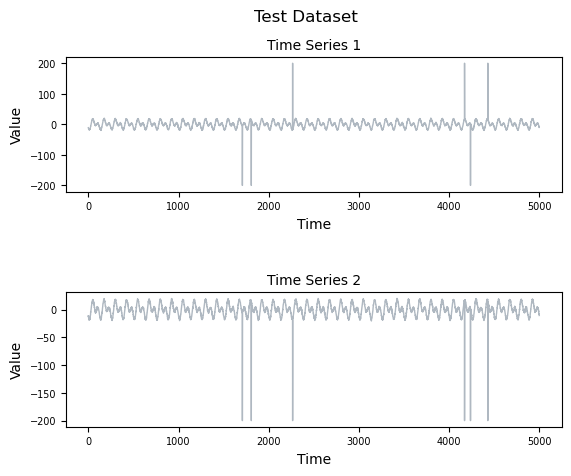

In [24]:
fig, axs = plt.subplots(nrows=test_dataset.shape[1], ncols=1, sharex=True)
for i in range(test_dataset.shape[1]):
    axs[i].plot(test_dataset.iloc[:, i], color="#AFB8C1", lw=1)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Test Dataset")
fig.show()

In [25]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/input/test.csv"
)

In [26]:
test_data

's3://sagemaker-eu-west-1-661670223746/data/inference/input/test.csv'

Given that the test dataset used in this experiment is relatively small, we invoke the endpoint using all the data.

In [27]:
payload = serializer.serialize(test_dataset.to_csv(index=False, header=False))

### C. Perform real-time inference

In [28]:
response = sagemaker_session.sagemaker_runtime_client.invoke_endpoint(
    EndpointName=predictor.endpoint_name,
    ContentType="text/csv",
    Body=payload
)

real_time_predictions = pd.DataFrame(data=deserializer.deserialize(response["Body"], content_type="text/csv")).replace("", None).astype(float)

In [29]:
response

{'ResponseMetadata': {'RequestId': 'e8c3fdc7-c373-43fa-b1ea-3656ba707bd4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'e8c3fdc7-c373-43fa-b1ea-3656ba707bd4',
   'x-amzn-invoked-production-variant': 'AllTraffic',
   'date': 'Wed, 13 Dec 2023 06:32:55 GMT',
   'content-type': 'application/json',
   'content-length': '284995',
   'connection': 'keep-alive'},
  'RetryAttempts': 0},
 'ContentType': 'application/json',
 'InvokedProductionVariant': 'AllTraffic',
 'Body': <botocore.response.StreamingBody at 0x7fc1e2141f30>}

In [30]:
real_time_results = sagemaker_session.upload_string_as_file_body(
    body=real_time_predictions.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/output/real-time/real_time_predictions.csv"
)

In [31]:
real_time_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/real-time/real_time_predictions.csv'

### D. Visualize output

The inference algorithm outputs the anomaly scores and the reconstructed values of the time series. The anomaly scores are included in the first column, while the reconstructed values of the time series are included in the subsequent columns.

In [32]:
real_time_predictions.shape

(5000, 3)

In [33]:
real_time_predictions.head()

,0,1,2
0,0.213033,-10.082997,-10.008846
1,2.609459,-11.104548,-10.988354
2,0.374179,-12.088655,-11.942144
3,0.674115,-13.018567,-12.862983
4,0.016431,-13.878198,-13.741350


In [34]:
real_time_predictions.tail()

,0,1,2
4995,0.569651,-6.276928,-6.373891
4996,0.951659,-7.366018,-7.371435
4997,1.287507,-8.471177,-8.356642
4998,1.147516,-9.265017,-9.136204
4999,1.174829,-10.226036,-10.182626


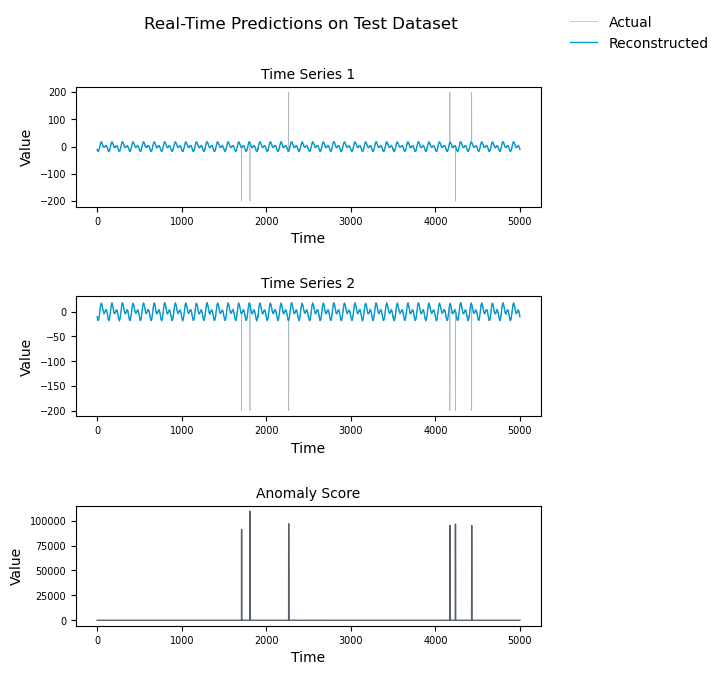

In [35]:
fig, axs = plt.subplots(nrows=test_dataset.shape[1] + 1, ncols=1, sharex=True, figsize=(6, 7))
for i in range(test_dataset.shape[1]):
    axs[i].plot(test_dataset.iloc[:, i], color="#AFB8C1", lw=0.5, label="Actual" if i == 0 else None)
    axs[i].plot(real_time_predictions.iloc[:, i + 1], color="#009ad3", lw=1, label="Reconstructed" if i == 0 else None)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
i += 1
axs[i].set_title("Anomaly Score", size=10)
axs[i].plot(real_time_predictions.iloc[:, 0], color="#57606a", lw=1)
axs[i].set(xlabel="Time", ylabel="Value")
axs[i].xaxis.set_tick_params(labelbottom=True)
axs[i].tick_params(axis="both", which="major", labelsize=7)
axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Real-Time Predictions on Test Dataset")
fig.legend(bbox_to_anchor=(1.2, 1, 0, 0), frameon=False)
fig.show()

### E. Calculate relevant metrics

If enough labelled anomalous data is available, you can estimate the optimal threshold on the anomaly score as the one that maximixes the F-beta score between the actual and predicted anomaly labels. Once the appropriate threshold has been determined, the model can be used as a binary classifier which predicts 1 (anomalous) if the anomaly score is above the threshold, and 0 (normal) if the anomaly score is below the threshold. After that the standard classification metrics (such as accuracy, precision, recall, etc.) can be computed as usual.

If [Amazon SageMaker Model Monitor](https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor.html) supports the type of problem you are trying to solve using this algorithm, use the following examples to add Model Monitor support to your product.
For sample code to enable and monitor the model, see following notebooks:
1. [Enable Amazon SageMaker Model Monitor](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/enable_model_monitor/SageMaker-Enable-Model-Monitor.ipynb)
2. [Amazon SageMaker Model Monitor - visualizing monitoring results](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker_model_monitor/visualization/SageMaker-Model-Monitor-Visualize.ipynb)

### F. Delete the endpoint

Now that you have successfully performed a real-time inference, you do not need the endpoint any more. You can terminate the same to avoid being charged.

In [36]:
predictor.delete_endpoint(delete_endpoint_config=True)

INFO:sagemaker:Deleting endpoint configuration with name: lstm-ae-endpoint-2023-12-13-06-27-35-851865
INFO:sagemaker:Deleting endpoint with name: lstm-ae-endpoint-2023-12-13-06-27-35-851865


Since this is an experiment, you do not need to run a hyperparameter tuning job. However, if you would like to see how to tune a model trained using a third-party algorithm with Amazon SageMaker's hyperparameter tuning functionality, you can run the optional tuning step.

## 5. Tune your model! (optional)

### A. Tuning Guidelines

The model has the following hyperparameters, all of which are tunable:
- `sequence-length`: `int`. The length of the sequences.
- `sequence-stride`: `int`. The period between consecutive sequences.
- `hidden-size`: `int`. The number of hidden units of each LSTM layer.
- `lr`: `float`. The learning rate used for training.
- `batch-size`: `int`. The batch size used for training.
- `epochs`: `int`. The number of training epochs.

### B. Define Tuning configuration

In [37]:
hyperparameter_ranges = {
    "hidden-size": sagemaker.parameter.IntegerParameter(32, 128),
    "lr": sagemaker.parameter.ContinuousParameter(0.001, 0.01),
    "batch-size": sagemaker.parameter.CategoricalParameter([32, 64]),
    "epochs": sagemaker.parameter.IntegerParameter(100, 200),
}

We use the validation mean absolute error (MAE) as the objective to be minimized.

In [38]:
objective_metric_name = "valid_mae"

In [39]:
objective_type = "Minimize"

### C. Run a model tuning job

In the interest of time, we run the tuner only for a few iterations. 

In [40]:
tuner = sagemaker.tuner.HyperparameterTuner(
    estimator=estimator,
    base_tuning_job_name="lstm-ae-tuning",
    objective_metric_name=objective_metric_name,
    objective_type=objective_type,
    hyperparameter_ranges=hyperparameter_ranges,
    max_jobs=4,
    max_parallel_jobs=4,
    random_seed=100,
)

In [41]:
tuner.fit({"training": training_data, "validation": validation_data})

INFO:sagemaker:Creating hyperparameter tuning job with name: lstm-ae-tuning-231213-0632


........................................................................................!


In [42]:
tuner.analytics().dataframe().sort_values(by="FinalObjectiveValue", ascending=True, ignore_index=True)

,batch-size,epochs,hidden-size,lr,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,32.0,184.0,79.0,0.002332,lstm-ae-tuning-231213-0632-001-e589bb78,Completed,0.080649,2023-12-13 06:34:20+00:00,2023-12-13 06:39:53+00:00,333.0
1,32.0,189.0,35.0,0.007927,lstm-ae-tuning-231213-0632-002-ecea7081,Completed,0.094749,2023-12-13 06:34:10+00:00,2023-12-13 06:39:23+00:00,313.0
2,64.0,197.0,75.0,0.009906,lstm-ae-tuning-231213-0632-004-384437a7,Completed,0.104588,2023-12-13 06:34:19+00:00,2023-12-13 06:39:12+00:00,293.0
3,64.0,121.0,64.0,0.009069,lstm-ae-tuning-231213-0632-003-553eb0ba,Completed,0.122665,2023-12-13 06:34:17+00:00,2023-12-13 06:38:29+00:00,252.0


In [43]:
tuning_job_result = sagemaker_session.sagemaker_client.describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.name
)

In [44]:
print("Best hyperparameters:")
tuning_job_result["BestTrainingJob"]["TunedHyperParameters"]

Best hyperparameters:


{'batch-size': '32',
 'epochs': '184',
 'hidden-size': '79',
 'lr': '0.002332046610717271'}

In [45]:
print("Best score:")
tuning_job_result["BestTrainingJob"]["FinalHyperParameterTuningJobObjectiveMetric"]["Value"]

Best score:


0.08064883947372437

Once you have completed a tuning job (or even while the job is still running), you can [clone and use this notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) to analyze the results to understand how each hyperparameter effects the quality of the model.

## 6. Perform Batch inference

In this section, you will perform batch inference.

In [46]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
)

INFO:sagemaker:Creating model package with name: lstm-ae-v1-4-2023-12-13-06-40-31-283


.........

INFO:sagemaker:Creating model with name: lstm-ae-v1-4-2023-12-13-06-40-31-283-2023-12-13-06-41-16-746


In [47]:
transformer.base_transform_job_name = "lstm-ae-transform"

In [48]:
transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating transform job with name: lstm-ae-transform-2023-12-13-06-41-17-485


2023-12-13T06:48:30,946 [WARN ] main org.pytorch.serve.util.ConfigManager - Your torchserve instance can access any URL to load models. When deploying to production, make sure to limit the set of allowed_urls in config.properties
2023-12-13T06:48:30,949 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-12-13T06:48:31,011 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-12-13T06:48:31,116 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.2
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Infer

In [49]:
batch_predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/test.csv.out"
)

batch_predictions = pd.read_csv(io.StringIO(batch_predictions), header=None, dtype=float)

In [50]:
batch_predictions.shape

(5000, 3)

In [51]:
batch_predictions.head()

,0,1,2
0,0.213033,-10.082997,-10.008846
1,2.609459,-11.104548,-10.988354
2,0.374179,-12.088655,-11.942144
3,0.674115,-13.018567,-12.862983
4,0.016431,-13.878198,-13.741350


In [52]:
batch_predictions.tail()

,0,1,2
4995,0.569651,-6.276928,-6.373891
4996,0.951659,-7.366018,-7.371435
4997,1.287507,-8.471177,-8.356642
4998,1.147516,-9.265017,-9.136204
4999,1.174829,-10.226036,-10.182626


In [53]:
np.all(np.isclose(batch_predictions.values, real_time_predictions.values))

True

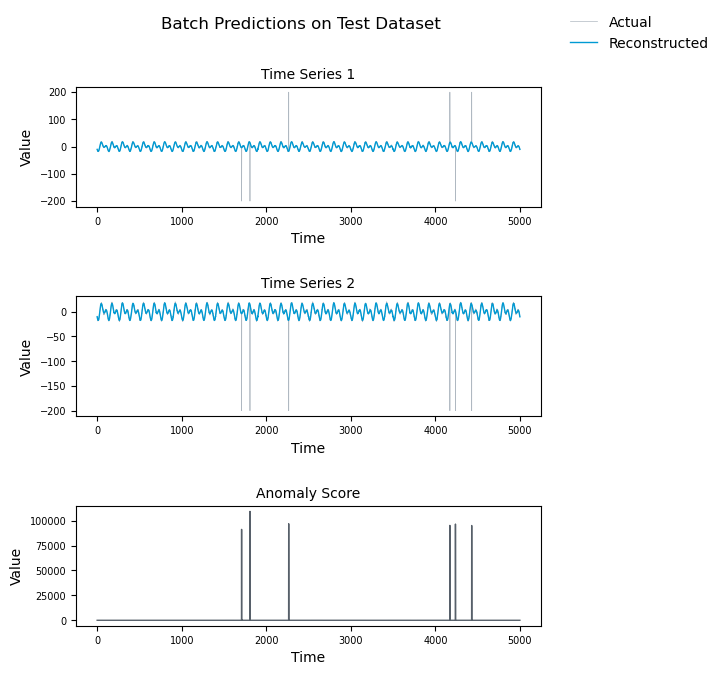

In [54]:
fig, axs = plt.subplots(nrows=test_dataset.shape[1] + 1, ncols=1, sharex=True, figsize=(6, 7))
for i in range(test_dataset.shape[1]):
    axs[i].plot(test_dataset.iloc[:, i], color="#AFB8C1", lw=0.5, label="Actual" if i == 0 else None)
    axs[i].plot(batch_predictions.iloc[:, i + 1], color="#009ad3", lw=1, label="Reconstructed" if i == 0 else None)
    axs[i].set_title(f"Time Series {i + 1}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
i += 1
axs[i].set_title("Anomaly Score", size=10)
axs[i].plot(batch_predictions.iloc[:, 0], color="#57606a", lw=1)
axs[i].set(xlabel="Time", ylabel="Value")
axs[i].xaxis.set_tick_params(labelbottom=True)
axs[i].tick_params(axis="both", which="major", labelsize=7)
axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.subplots_adjust(hspace=0.75)
fig.suptitle("Batch Predictions on Test Dataset")
fig.legend(bbox_to_anchor=(1.2, 1, 0, 0), frameon=False)
fig.show()

In [55]:
batch_results = sagemaker_session.upload_string_as_file_body(
    body=batch_predictions.to_csv(index=False, header=False),
    bucket=bucket,
    key="data/inference/output/batch/batch_predictions.csv"
)

In [56]:
batch_results

's3://sagemaker-eu-west-1-661670223746/data/inference/output/batch/batch_predictions.csv'

## 7. Clean-up

### A. Delete the model

In [57]:
transformer.delete_model()

INFO:sagemaker:Deleting model with name: lstm-ae-v1-4-2023-12-13-06-40-31-283-2023-12-13-06-41-16-746


### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the algorithm, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

